In [59]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.spatial.transform import Rotation
import numpy as np

In [60]:
data = make_blobs(n_samples=300, centers=5, n_features=3)

angles = [0, 15, 30, 45, 60]
theta = np.radians(angles)

domains = []
for i in range(len(theta)):
    rotation_matrix = Rotation.from_euler('z', theta[i]).as_matrix()
    data_rotated = np.dot(data[0], rotation_matrix)
    domains.append(data_rotated)

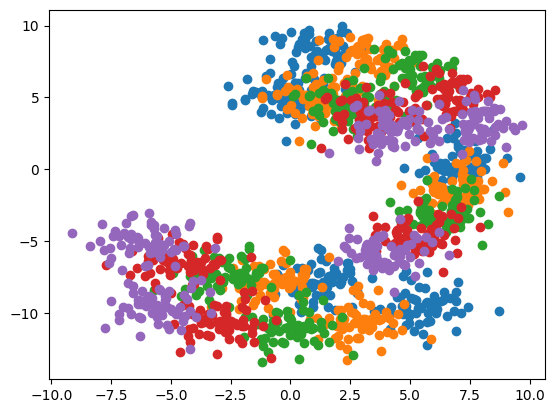

In [61]:
fig, ax = plt.subplots()
for i in range(len(domains)):
    ax.scatter(domains[i][:, 0], domains[i][:, 1])

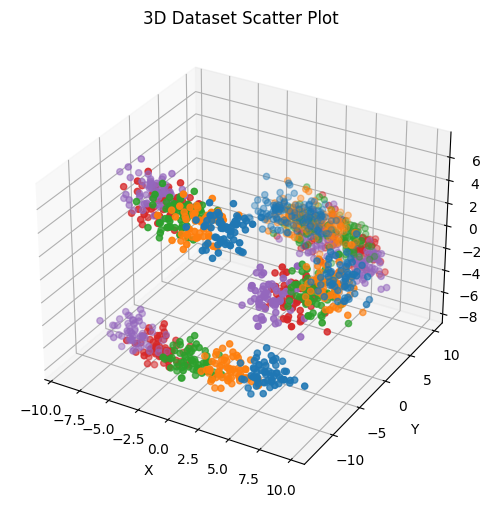

In [62]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the 3D dataset
for i in range(len(domains)):
    ax.scatter(domains[i][:, 0], domains[i][:, 1], domains[i][:, 2])

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set title
ax.set_title('3D Dataset Scatter Plot')

plt.show()


In [63]:
transformation_matrix = np.random.rand(3, 100)
high_dim_domains = []
for i in range(len(domains)):
    high_dim_domains.append(np.dot(domains[i], transformation_matrix))

In [64]:
for i in range(len(high_dim_domains)):
    high_dim_domains[i] = np.concatenate((high_dim_domains[i], data[1].reshape(-1, 1)), axis=1)

In [65]:
toy_dataset = np.concatenate((high_dim_domains[0], np.zeros((high_dim_domains[0].shape[0], 1))), axis=1)

for i in range(1, len(high_dim_domains)):
    data_to_concatenate = np.concatenate((high_dim_domains[i], i * np.ones((high_dim_domains[0].shape[0], 1))), axis=1)
    toy_dataset = np.concatenate((toy_dataset, data_to_concatenate), axis=0)

In [67]:
np.save('high_dimension_toy_dataset.npy', toy_dataset)

In [75]:
import skdim
import numpy as np

#estimate global intrinsic dimension
danco = skdim.id.DANCo().fit(toy_dataset[:, :-2])
#estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
lpca = skdim.id.lPCA().fit_pw(toy_dataset[:, :-2],
                              n_neighbors = 100,
                              n_jobs = 1)

#get estimated intrinsic dimension
print(danco.dimension_, np.mean(lpca.dimension_pw_))

3.304146016110396 2.9806666666666666
